# Goal

# Project Plan

- acquire at least 

In [ ]:


Predict missing values from the data set using clustering
Derive insights on "Armstrong", the person from whom the fitness data was generated
Hypotheses
There are patterns on Armstrong's daily activities.
Armstrong's fitness activity is affected by the month/season of the year.
Data Science Skills Used
Data prep and cleaning
Time Series Analysis
Visualization
Modeling using Parametric Methods
Modeling using the Prophet algorithm
Evaluation of Models

# Data Dictionary

## Summary of Data

In [3]:
# imports
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from selenium import webdriver
from selenium.webdriver.firefox.options import Options
import requests
from bs4 import BeautifulSoup as bs
import re
import pandas as pd
import os

import prepare

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

#import acquire

In [ ]:
def basic_clean(data):
    data['target'] = data['readme'].apply(lambda x: x.replace('GitHub is home to over 40 million developers working together to host and review code, manage projects, and build software together.',''))
    data.rename(columns = {'language':'label'}, inplace = True)
    data.drop(columns = ['link', 'readme','Unnamed: 0','index'], inplace = True)
    return data

In [200]:
def normalize(string):
    """
    Convert to all lowercase  
    Normalize the unicode chars  
    Remove any non-alpha or whitespace characters  
    Remove any alpha strings with 2 characters or less  
    """
    string = string.lower()
    string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # keep only alpha chars
    string = re.sub(r'[^a-z]', ' ', string)
    
    # remove strings less than 2 chars in length
    string = re.sub(r'\b[a-z]{,2}\b', '', string)
    
    # convert newlines and tabs to a single space
    string = re.sub(r'[\r|\n|\r\n]+', ' ', string)
    
    # strip extra whitespace
    string = string.strip()
    
    return string

def stem(string):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    string_of_stems = ' '.join(stems)
    return string_of_stems

def lemmatize(string):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    string_of_lemmas = ' '.join(lemmas)
    return string_of_lemmas

def tokenize(string):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(string, return_str=True)

def remove_stopwords(tokenized_string, extra_words=[], exclude_words=[]):
    words = tokenized_string.split()
    stopword_list = stopwords.words('english')

    # remove the excluded words from the stopword list
    stopword_list = set(stopword_list) - set(exclude_words)

    # add in the user specified extra words
    stopword_list = stopword_list.union(set(extra_words))

    filtered_words = [w for w in words if w not in stopword_list]
    final_string = " ".join(filtered_words)
    return final_string

def prep_target(df, col):
    #df[col] = df[col].apply(', '.join)
    df = df.assign(original = df[col])
    #df = df['original'].apply(', '.join)
    df = df.assign(normalized = df.original.apply(normalize))
    df = df.assign(stemmed = df.normalized.apply(stem))
    df = df.assign(lemmatized = df.normalized.apply(lemmatize))
    df = df.assign(cleaned = df.lemmatized.apply(remove_stopwords))
    #df.drop(columns=["title"], inplace=True)
    return df

In [4]:
df = pd.read_csv('hola.csv')
df.head()

,Unnamed: 0,index,language,link,readme
0,0,0,JavaScript,freeCodeCamp/freeCodeCamp,['GitHub is home to over 40 million developers...
1,1,1,Rust,996icu/996.ICU,['GitHub is home to over 40 million developers...
2,2,2,JavaScript,vuejs/vue,['GitHub is home to over 40 million developers...
3,3,3,JavaScript,facebook/react,['GitHub is home to over 40 million developers...
4,4,4,C++,tensorflow/tensorflow,['GitHub is home to over 40 million developers...


In [5]:
df = prepare.prep_target(df, 'target')

In [6]:
df.head()

,label,target,original,normalized,stemmed,lemmatized,cleaned
0,JavaScript,"['', '', '\n\n\n', 'freeCodeCamp.org is a frie...","['', '', '\n\n\n', 'freeCodeCamp.org is a frie...",freecodecamp org friendly community where yo...,freecodecamp org friendli commun where you can...,freecodecamp org friendly community where you ...,freecodecamp org friendly community learn code...
1,Rust,"['', 'Please note that there exists NO other o...","['', 'Please note that there exists NO other o...",please note that there exists other official ...,pleas note that there exist other offici accou...,please note that there exists other official a...,please note exists official account app mercha...
2,JavaScript,"['', '', '\n\n\n\n\n\n\n\n\n', ""Vue.js is an M...","['', '', '\n\n\n\n\n\n\n\n\n', ""Vue.js is an M...",vue mit licensed open source project in...,vue mit licens open sourc project independ pro...,vue mit licensed open source project independe...,vue mit licensed open source project independe...
3,JavaScript,"['', 'React is a JavaScript library for buildi...","['', 'React is a JavaScript library for buildi...",react javascript library for building user i...,react javascript librari for build user interf...,react javascript library for building user int...,react javascript library building user interfa...
4,C++,"['', 'TensorFlow is an end-to-end open source ...","['', 'TensorFlow is an end-to-end open source ...",tensorflow end end open source platform nfo...,tensorflow end end open sourc platform nfor ma...,tensorflow end end open source platform nfor m...,tensorflow end end open source platform nfor m...


In [246]:
def clean():
    "a simple function to prepare text data"
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words("english") + ["r", "u", "2", "ltgt"]
    text = (
        unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
        .lower()
    )
    words = re.sub(r"[^\w\s]", "", text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [304]:
#cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 7 columns):
label         165 non-null object
target        165 non-null object
original      165 non-null object
normalized    165 non-null object
stemmed       165 non-null object
lemmatized    165 non-null object
cleaned       165 non-null object
dtypes: object(7)
memory usage: 9.1+ KB


In [7]:
pd.concat(
    [df.label.value_counts(), df.label.value_counts(normalize=True)], axis=1
).set_axis(["n", "percent"], axis=1, inplace=False)

,n,percent
JavaScript,61,0.369697
Python,21,0.127273
Java,15,0.090909
C++,14,0.084848
Go,9,0.054545
TypeScript,9,0.054545
C,4,0.024242
Rust,3,0.018182
Vue,3,0.018182
Shell,3,0.018182


Text(0.5, 1.0, 'Most frequently used programing languages')

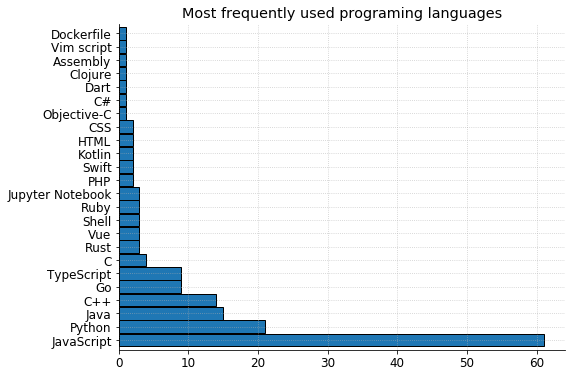

In [10]:
df.label.value_counts().plot.barh(figsize=(8, 6),width = .95)
plt.title('Most frequently used programing languages')

**Question** Is there any particular sentiment with particular language?

In [255]:
string_readme = " ".join(cleaned_df.cleaned) # turn into string for prep
readme = [string_readme]

In [282]:
cleaned_df = cleaned_df[['label','cleaned']].set_index('label')

In [283]:
documents = cleaned_df.to_dict()

In [286]:
cleaned_list = [cleaned_df.cleaned]

In [13]:
df = df[['label','cleaned']]

In [39]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.cleaned)
y = df.label

In [37]:
df = df.groupby('label').filter(lambda x : len(x)>1)

In [46]:
df = df.groupby('label').filter(lambda x : len(x)>13)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

In [48]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [49]:
train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [50]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 42.86%
---
Confusion Matrix
actual      C  C++  CSS  Go  HTML  Java  JavaScript  Jupyter Notebook  Kotlin  \
predicted                                                                       
JavaScript  2   11    2   7     2     8          47                 2       1   
Python      1    0    0   0     0     4           2                 0       1   

actual      PHP  Python  Ruby  Rust  Shell  Swift  TypeScript  Vue  
predicted                                                           
JavaScript    2      10     2     2      2      2           7    2  
Python        0       7     0     0      0      0           0    0  
---
                  precision    recall  f1-score   support

               C       0.00      0.00      0.00         3
             C++       0.00      0.00      0.00        11
             CSS       0.00      0.00      0.00         2
              Go       0.00      0.00      0.00         7
            HTML       0.00      0.00      0.00         2
        

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [51]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 31.25%
---
Confusion Matrix
actual      C  C++  Go  Java  JavaScript  Jupyter Notebook  Python  Ruby  \
predicted                                                                  
JavaScript  0    3   2     3          10                 1       4     0   
Python      1    0   0     0           2                 0       0     1   

actual      Rust  Shell  TypeScript  Vue  
predicted                                 
JavaScript     1      1           2    1  
Python         0      0           0    0  
---
                  precision    recall  f1-score   support

               C       0.00      0.00      0.00         1
             C++       0.00      0.00      0.00         3
              Go       0.00      0.00      0.00         2
            Java       0.00      0.00      0.00         3
      JavaScript       0.36      0.83      0.50        12
Jupyter Notebook       0.00      0.00      0.00         1
          Python       0.00      0.00      0.00         4
            Ruby